# Make Predictions for Upcoming IPO
- Retrieves upcoming IPO from NASDAQ
- Lists probabilities for upcoming peformance
 - 1D, 1W, 1M and 3M outcome prediction

In [1]:
import numpy as np
import pandas as pd

import nasdaq
import ml

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
#params
today = datetime.datetime.today()
start_date = str(datetime.datetime(today.year, today.month-1, 1).date())
print('predictions for', start_date)

predictions for 2018-06-01


# Create NASDAQ IPO List

In [3]:
df_symbols = nasdaq.get_ipo_list(start_date)
print('symbols', df_symbols.shape[0])

date range: odict_keys(['2018-06', '2018-07'])
symbols 39


In [4]:
df_symbols.head()

,Company Name,Symbol,Market,Price,Shares,Offer Amount,Date Priced
Symbol,,,,,,,
DOMO,"DOMO, INC.",DOMO,NASDAQ Global,21.0,9200000,193200000.0,2018-06-29
STIM,"NEURONETICS, INC.",STIM,NASDAQ Global,17.0,5500000,93500000.0,2018-06-28
TBIO,"TRANSLATE BIO, INC.",TBIO,NASDAQ Global Select,13.0,9350000,121550000.0,2018-06-28
TCDA,"TRICIDA, INC.",TCDA,NASDAQ Global Select,19.0,11700000,222300000.0,2018-06-28
NFC'U,NEW FRONTIER CORP,NFC'U,NYSE,10.0,25000000,250000000.0,2018-06-28


# Train Models (RF/LR - Train/Test Split)

In [5]:
#load most up to date data
df = pd.read_csv('../Datasets/4 keywords.csv', index_col='Symbol')

#quarter and month
months = df.loc[:, 'Q1':'MKT12'].columns
classes = df.loc[:, '1D':'3M'].columns
others = df.columns.difference(months).difference(classes)

#standardize
df = pd.concat([ml.standardize(df[others]), df[months], df[classes]], axis=1)

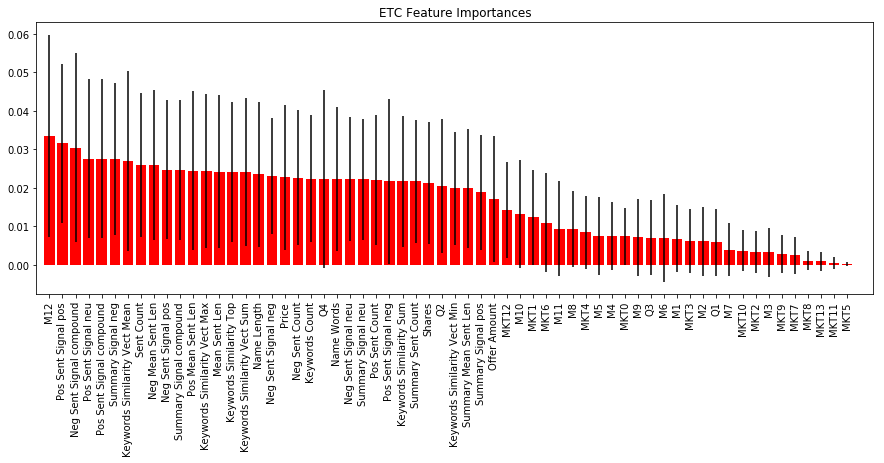

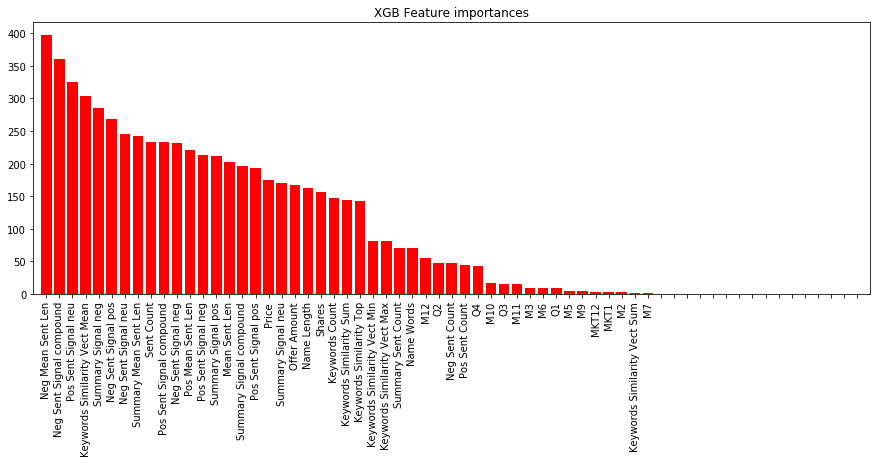

In [6]:
#feature importance
indices = ml.show_feature_importance(df, '3M')

In [7]:
#feature selection
df1 = ml.select_features(indices.shape[0], indices, df)

['Keywords Similarity Vect Mean', 'Summary Signal neg', 'Neg Sent Signal compound', 'Pos Sent Signal compound', 'Pos Sent Signal neu', 'Pos Sent Signal pos', 'Neg Mean Sent Len', 'M12']


C:\Users\Void\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


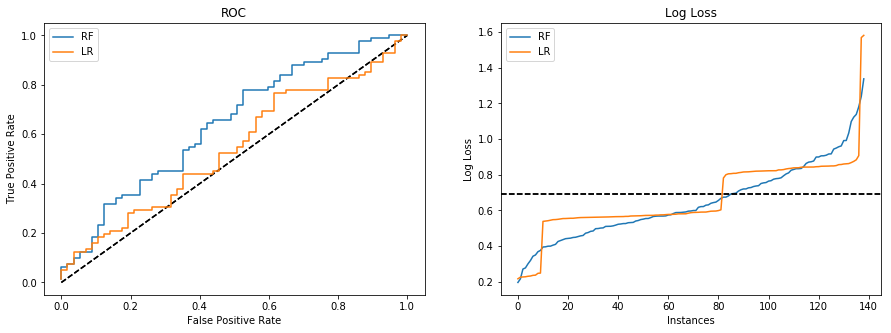

1D        1W        1M        3M
AUC      LR       0.5       0.5       0.5       0.5
         RF  0.551134  0.551134  0.551134  0.551134
f1       LR  0.742081  0.742081  0.742081  0.742081
         RF  0.741463  0.741463  0.741463  0.741463
log loss LR  0.665032  0.665032  0.665032  0.665032
         RF  0.647009  0.647009  0.647009  0.647009

In [8]:
#run ML flow
ml.run_ml_flow(df1)

# Train Model (Ensemble - Entire Data)

In [9]:
#prepare test set
targets = ['1D', '1W', '1M', '3M']
df_symbols = df.loc[df_symbols.index]

#drop targets
df_symbols.drop(targets, axis=1, inplace=True)

#drop columns with nanas
df_symbols.dropna(axis=1, inplace=True)

df_symbols.head()

,Q1,Q2,Q3,Q4,M1,M2,M3,M4,M5,M6,...,MKT9,MKT10,MKT11,MKT12,MKT13,Name Words,Name Length,Offer Amount,Price,Shares
Symbol,,,,,,,,,,,,,,,,,,,,,
DOMO,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,10,193200000.0,21.0,9200000
STIM,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,17,93500000.0,17.0,5500000
TBIO,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,3,19,121550000.0,13.0,9350000
TCDA,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,13,222300000.0,19.0,11700000
NFC'U,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,3,17,250000000.0,10.0,25000000


In [10]:
# align train and test frames
df = df.dropna()
df = df[list(df_symbols.columns) + targets]

In [16]:
#train & predict for all targets
prediction = pd.DataFrame(columns=targets, index=df_symbols.index)
X_test = df_symbols.values

for target in targets:

    #split
    X_train = df.values[:,:-4]
    y_train = df[target].map(lambda x: 1 if x > 0 else 0).values

    #classifier
    clf = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)), ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=1))], voting='soft')

    #fit
    clf.fit(X_train, y_train)

    #predict
    probas = clf.predict_proba(X_test)
    prediction[target] = probas[:,1]

# Show Predictions

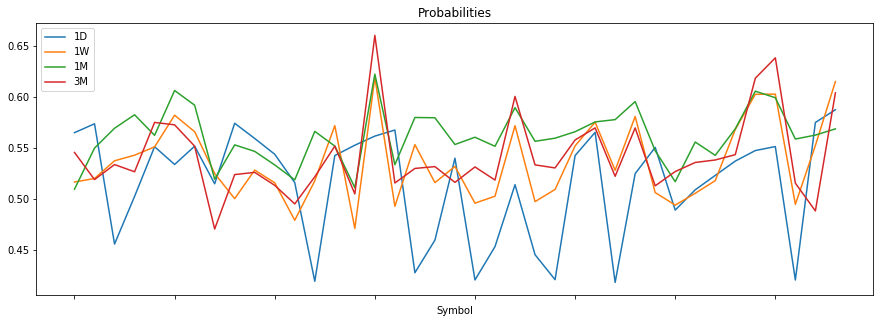

In [17]:
prediction.plot(figsize=(15,5), title='Probabilities')

In [18]:
prediction.tail(10)

,1D,1W,1M,3M
Symbol,,,,
VRCA,0.550516,0.506244,0.547206,0.512838
NEW,0.489007,0.493931,0.516916,0.526819
AVLR,0.508936,0.505516,0.555776,0.535742
CHRA,0.523042,0.517920,0.542729,0.538168
USX,0.537083,0.568160,0.568746,0.543398
FPACU,0.547410,0.602563,0.605661,0.618350
GSAHU,0.551328,0.602748,0.599222,0.638340
MGTX,0.420460,0.494677,0.558710,0.515455
AMBO,0.574962,0.552362,0.562572,0.488216
